## 1.Initialization

Newton's second law for the classical mass spring smaper system.

$m\ddot{x} = - c\dot{x} - kx$

We make the substitution

$\dot{x} = v$

and write system in state space form,

$\dot{x} = v\\
\dot{v} = - \frac{c}{m}v - \frac{k}{m}x.$

In this case we neglect damping, meaning that

$c = 0$

resulting in the final system in state space form,

$\dot{x} = v\\
\dot{v} =  - \frac{k}{m}x.$

In [193]:
import numpy as np
import pysindy as ps

from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

In [194]:
#initialization

dt = .005 #integtration time step
t = np.arange(0, 10, dt) #integration length

#x_0 = np.array([1,0,0])  #Initial state of observer in the form [x1_0,x2_dot_0,z]
#y_0 = np.array([-1,0,2])  #Initial state of feature in the form [y1_0,y2_dot_0,z]




### Generate data for the Observer.

In [195]:
param_1 = 1 #Observer parameter k/m

def observer(x, t): #Observer System
    return [
        x[1], #x_1 dot
        -param_1*x[0]] #x_2 dot

x_0 = [1, 0]  # Observer Initial Conditions
x_3 = 0 #third dimension used to calculate distance between observer and feature

x = odeint(observer, x_0, t) # Generate measurement data in form [x1, x2]
x




array([[ 1.        ,  0.        ],
       [ 0.9999875 , -0.00499997],
       [ 0.99995   , -0.00999982],
       ...,
       [-0.84713738,  0.53137423],
       [-0.84446993,  0.53560326],
       [-0.84178137,  0.53981889]])

### Generate date for the Feature.

In [196]:
param_2 = 2 #Feature parameter k/m

def feature(y, t): #Feature System
    return [
        y[1], #y1 dot
        -param_2*y[0]] #y2 dot

y_0 = [-1, 0] # Observer Initial Conditions
y_3 = 1 # distance from observer

y = odeint(feature, y_0, t) # Generate measurement data in form [y1, y2]
y

array([[-1.        ,  0.        ],
       [-0.999975  ,  0.00999991],
       [-0.9999    ,  0.01999932],
       ...,
       [-0.01624411,  1.41402717],
       [-0.00917363,  1.41415426],
       [-0.00210269,  1.41421064]])

<ipython-input-197-5aa398db1b5d>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


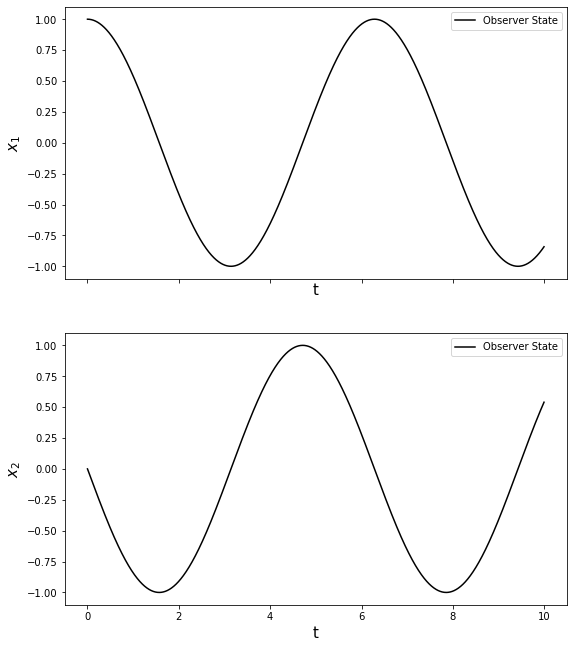

In [197]:
fig, axs = plt.subplots(x.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(x.shape[1]):
    axs[i].plot(t, x[:, i], 'k', label='Observer State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$x_{}$'.format(i+1), fontsize = 15)
fig.show()

<ipython-input-198-38370a67842b>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


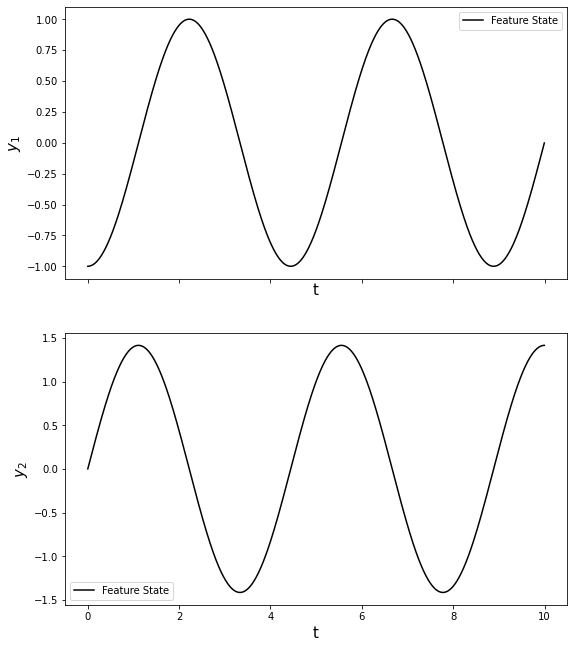

In [198]:
fig, axs = plt.subplots(y.shape[1], 1, sharex=True, figsize=(9, 11))
for i in range(y.shape[1]):
    axs[i].plot(t, y[:, i], 'k', label='Feature State')
    #axs[i].plot(t_test, x_test_sim[:, i], 'r--', label='model simulation')
    axs[i].legend()
    #axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i+1))
    axs[i].set_xlabel('t', fontsize = 15)
    axs[i].set_ylabel('$y_{}$'.format(i+1), fontsize = 15)
fig.show()

## 2.Simulate Sensors
### Observer IMU sensor simulation

In [199]:
acc = -param_1*x[:,0]
acc

#Stochastic IMU sensor
imu_mean = 0
imu_std = 0.01

acc_noise = acc+np.random.normal(imu_mean,imu_std,size=imu.shape)



### Relative position sensor simulation

In [200]:
# Nominal Sensor on the observer
delta = y-x
delta

#Stochastic sensor on the observer
rel_sense_mean = 0 #mean of relative measurement sensor
rel_sense_std = (x[0,0]-y[0,0]) * 0.01 #standard deviation of relative measurement scales with the distance

delta_noise = delta + np.random.normal(rel_sense_mean,rel_sense_std,size=delta.shape)




## 3.Learn Relative Dynamics
### Define SINDy options

In [201]:
differentiation_method = ps.FiniteDifference(order=2)

optimizer = ps.STLSQ(threshold=0.2)
lasso_optimizer = Lasso(alpha=0.001, max_iter=2000, fit_intercept=False)
sr3_optimizer = ps.SR3(threshold=0.1, nu=1)

poly_library = ps.PolynomialLibrary()
fourier_library = ps.FourierLibrary()
identity_library = ps.IdentityLibrary()
combined_library = poly_library #+ identity_library #+ fourier_library

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=combined_library,
    optimizer=sr3_optimizer)




### Learn Relative Dynamics from Relative State Sensor
#### -Learn model using SINDy on nominal data
#### -Compare actual relative dynamics to learned relative dynamics

x0' = 1.000 x1
x1' = -1.521 x0 + -0.171 x1
Model score: 0.931509
<ipython-input-202-cdeffdb274a0>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


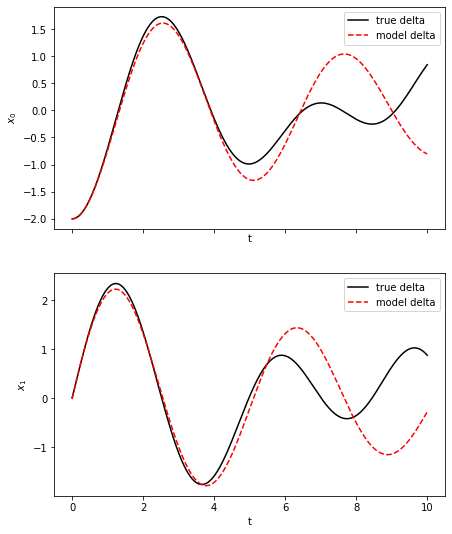

In [202]:
model.fit(delta, t=dt)
model.print()
print('Model score: %f' % model.score(delta, t=dt))

delta_0 = [-2, 0]
delta_sim = model.simulate(delta_0, t)

fig, axs = plt.subplots(delta.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(delta.shape[1]):
    axs[i].plot(t, delta[:, i], 'k', label='true delta')
    axs[i].plot(t, delta_sim[:, i], 'r--', label='model delta')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()




### -Learn model using SINDy on noisy data
### -Compare actual relative dynamics to learned relative dynamics

x0' = 1.000 x1
x1' = -1.521 x0 + -0.171 x1
Model score: 0.144994
<ipython-input-203-cd5b55406280>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


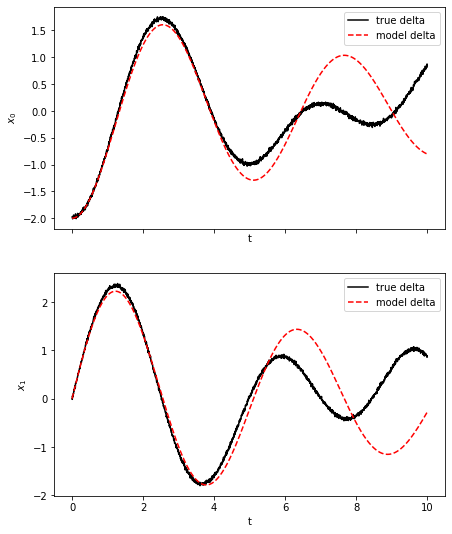

In [203]:
model.fit(delta, t=dt)
model.print()
print('Model score: %f' % model.score(delta_noise, t=dt))

delta_0 = [-2, 0]
delta_sim = model.simulate(delta_0, t)

fig, axs = plt.subplots(delta_noise.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(delta.shape[1]):
    axs[i].plot(t, delta_noise[:, i], 'k', label='true delta')
    axs[i].plot(t, delta_sim[:, i], 'r--', label='model delta')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig.show()




## 4.Observer State Estimation
### Dead Reckoning with noisy IMU 

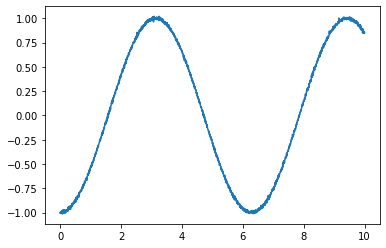

In [204]:
plt.plot(t,acc_noise) #acceleration of observer over time

1999

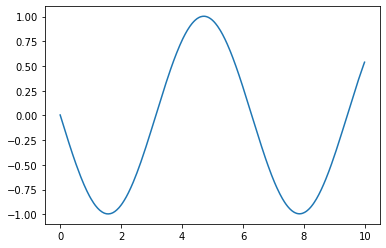

In [229]:
vel_noise = np.zeros(acc_noise.size-1)

#Integrate Acceleration
for x in range(vel_noise.size):
    vel_noise[x] = acc_noise[x-1]*dt+vel_noise[x-1]

plt.plot(t[0:vel_noise.size],vel_noise) # velocity of observer over time
vel_noise.size

1998

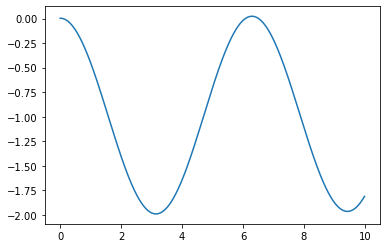

In [230]:
pos_noise = np.zeros(vel_noise.size-1)
pos_noise[0] = 1
#Integrate Acceleration
for x in range(pos_noise.size):
    pos_noise[x] = vel_noise[x-1]*dt+pos_noise[x-1]

plt.plot(t[0:pos_noise.size],pos_noise) # velocity of observer over time
pos_noise.size
